# Spam or ham

## Loading the data

In [1]:
raw_text = open(r'SMSSpamCollection', encoding = 'utf-8')

In [2]:
lines = [line.rstrip() for line in raw_text]

In [3]:
print(len(lines))

5574


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv(r'SMSSpamCollection', sep = '\t', names = ['Label', 'Message'])

In [6]:
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## EDA

In [7]:
df.groupby('Label').describe()

Message
Label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In [8]:
df['length'] = df['Message'].apply(len)

In [9]:
df.head()

,Label,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [10]:
import matplotlib.pyplot as plt

In [11]:
%matplotlib inline

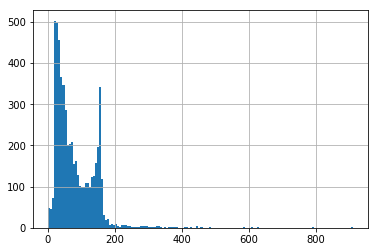

In [12]:
df['length'].hist(bins = 150)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fda0b1851d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fda0b090b38>], dtype=object)

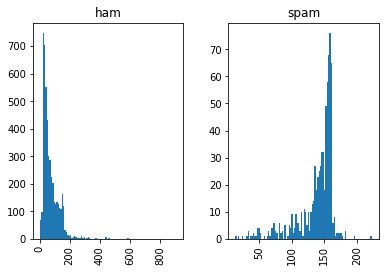

In [13]:
df.hist(column = 'length', by = 'Label', bins = 100)

## Preprocessing

In [14]:
import nltk
from string import punctuation
from nltk.corpus import stopwords

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
def clean(msg):
    chars = [char for char in msg if char not in punctuation]
    chars = ''.join(chars)
    return [word.lower() for word in msg.split() if word.lower() not in stopwords.words('english')]

In [17]:
df['Message'].apply(clean)

0       [go, jurong, point,, crazy.., available, bugis...
1                    [ok, lar..., joking, wif, u, oni...]
2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
3       [u, dun, say, early, hor..., u, c, already, sa...
4         [nah, think, goes, usf,, lives, around, though]
5       [freemsg, hey, darling, 3, week's, word, back!...
6       [even, brother, like, speak, me., treat, like,...
7       [per, request, 'melle, melle, (oru, minnaminun...
8       [winner!!, valued, network, customer, selected...
9       [mobile, 11, months, more?, u, r, entitled, up...
10      [i'm, gonna, home, soon, want, talk, stuff, an...
11      [six, chances, win, cash!, 100, 20,000, pounds...
12      [urgent!, 1, week, free, membership, £100,000,...
13      [i've, searching, right, words, thank, breathe...
14                                 [date, sunday, will!!]
15      [xxxmobilemovieclub:, use, credit,, click, wap...
16                        [oh, k...i'm, watching, here:)]
17      [eh, u

## Vectorizing

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
bow_transformer = CountVectorizer(analyzer = clean)

In [20]:
bow_transformer.fit(df['Message'])

CountVectorizer(analyzer=<function clean at 0x7fda0b093488>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [21]:
print(len(bow_transformer.vocabulary_))

13429


In [22]:
bow_messages = bow_transformer.transform(df['Message'])

In [23]:
print(bow_messages.shape)

(5572, 13429)


In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

In [25]:
tfidf_transformer = TfidfTransformer().fit(bow_messages)

In [26]:
tfidf_messages = tfidf_transformer.transform(bow_messages)

In [27]:
print(tfidf_messages.shape)

(5572, 13429)


## Prediction

In [28]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(tfidf_messages, df['Label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
predicted = clf.predict(tfidf_messages)

## Evaluation

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
print(confusion_matrix(df['Label'], predicted))

[[4825    0]
 [ 122  625]]


In [32]:
print(classification_report(df['Label'], predicted))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.84      0.91       747

avg / total       0.98      0.98      0.98      5572



## Separate test set

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Label'], random_state = 5)

In [35]:
from sklearn.pipeline import Pipeline

In [36]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer = clean)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [37]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function clean at 0x7fda0b093488>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
   ...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [38]:
predicted = pipeline.predict(X_test)

In [39]:
print(confusion_matrix(y_test, predicted), '\n', classification_report(y_test, predicted))

[[1205    0]
 [  65  123]] 
              precision    recall  f1-score   support

        ham       0.95      1.00      0.97      1205
       spam       1.00      0.65      0.79       188

avg / total       0.96      0.95      0.95      1393

